In [1]:
import asyncio 
import matplotlib

import numpy as np
import pandas as pd

from matplotlib import pylab as plt
from astropy.time import Time, TimeDelta

from lsst_efd_client import EfdClient, resample

%matplotlib inline

In [2]:
efd_client = EfdClient('summit_efd')

In [72]:
query = f'SELECT "message" FROM "efd"."autogen"."lsst.sal.Script.logevent_logMessage" where "private_host" = 170525220.00'



In [73]:
query

'SELECT "message" FROM "efd"."autogen"."lsst.sal.Script.logevent_logMessage" where "private_host" = 170525220.00'

In [142]:
msg = await efd_client.influx_client.query(query)

In [143]:
lut_times = []

for i in range(len(msg)):
    if "LUT" in msg["message"][i]:
        lut_times.append(Time(msg.index[i], scale='tai'))


In [144]:
print(len(lut_times))

24


In [145]:
out_data = np.zeros(len(lut_times), dtype=[('az', float), 
                                        ('el', float), 
                                        ('rot_pos', float),
                                        ('x', float), 
                                        ('y', float), 
                                        ('z', float)])

In [146]:
for i in range(len(lut_times)):

    t1 = lut_times[i] - TimeDelta(5., format='sec', scale='tai')
    t2 = lut_times[i] + TimeDelta(5., format='sec', scale='tai')

    azel = await efd_client.select_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", 
                                               ["elevationCalculatedAngle99", "azimuthCalculatedAngle99"], 
                                               t1 - TimeDelta(37., format='sec', scale='tai'), 
                                               t2 - TimeDelta(37., format='sec', scale='tai'))
    rotator = await efd_client.select_time_series("lsst.sal.ATMCS.mount_Nasmyth_Encoders",
                                                  ["nasmyth1CalculatedAngle99"], 
                                                  t1 - TimeDelta(37., format='sec', scale='tai'), 
                                                  t2 - TimeDelta(37., format='sec', scale='tai'))
    hexapod = await efd_client.select_time_series("lsst.sal.ATHexapod.positionStatus",
                                                  ["reportedPosition0", "reportedPosition1", "reportedPosition2"], t1, t2)

    rot_pos = np.mean(rotator['nasmyth1CalculatedAngle99'])
    el = np.mean(azel['elevationCalculatedAngle99'])
    az = np.mean(azel['azimuthCalculatedAngle99'])
    x = np.mean(hexapod['reportedPosition0'])
    y = np.mean(hexapod['reportedPosition1'])
    z = np.mean(hexapod['reportedPosition2'])
    
    out_data[i] = (az, el, rot_pos, x, y, z)

    

In [147]:
# out_data

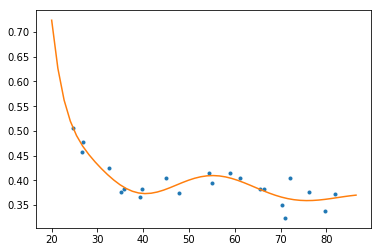

In [171]:
fit_z = np.polyfit(np.cos(np.radians(90. - out_data['el'][2:])), out_data['z'][2:], 7)
poly_z = np.poly1d(fit_z)
rev_poly_z = np.poly1d(fit_z[::-1])

el = np.linspace(20, 86.5)

plt.plot(out_data['el'][2:], out_data['z'][2:], '.')
plt.plot(el, poly_z(np.cos(np.radians(90. - el))))
# plt.plot(el, rev_poly_z(np.cos(np.radians(90. - el))))

In [162]:
for coeff in fit_z:
    print(f"- {coeff:+14.3f}")

-       -279.386
-      +1676.871
-      -4064.106
-      +5214.778
-      -3855.691
-      +1654.010
-       -384.112
-        +38.008


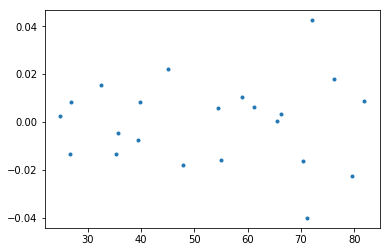

In [161]:
plt.plot(out_data['el'][2:], out_data['z'][2:]-poly_z(np.cos(np.radians(90. - out_data['el'][2:]))), '.')

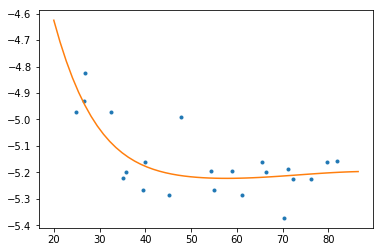

In [172]:
fit_x = np.polyfit(np.cos(np.radians(90. - out_data['el'][2:])), out_data['x'][2:], 4)
poly_x = np.poly1d(fit_x)
rev_poly_x = np.poly1d(fit_x[::-1])

plt.plot(out_data['el'][2:], out_data['x'][2:], '.')
plt.plot(el, poly_x(np.cos(np.radians(90. - el))))

In [163]:
for coeff in fit_x:
    print(f"- {coeff:+14.3f}")

-         +6.285
-        -20.969
-        +27.138
-        -16.115
-         -1.535


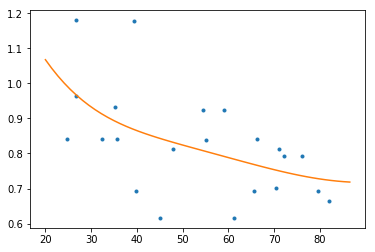

In [173]:
fit_y = np.polyfit(np.cos(np.radians(90. - out_data['el'][2:])), out_data['y'][2:], 3)
poly_y = np.poly1d(fit_y)
rev_poly_y = np.poly1d(fit_y[::-1])

plt.plot(out_data['el'][2:], out_data['y'][2:], '.')
plt.plot(el, poly_y(np.cos(np.radians(90. - el))))

In [164]:
for coeff in fit_y:
    print(f"- {coeff:+14.3f}")

-         -1.741
-         +3.850
-         -3.158
-         +1.767


In [168]:
poly_x(np.cos(np.radians(90. - 80.))), poly_y(np.cos(np.radians(90. - 80.))), poly_z(np.cos(np.radians(90. - 80.)))

(-5.201578241362627, 0.7272491726827441, 0.36189447874301806)

In [174]:
rev_poly_x(np.cos(np.radians(90. - 80.))), rev_poly_y(np.cos(np.radians(90. - 80.))), rev_poly_z(np.cos(np.radians(90. - 80.)))

(-4.881222802729967, 0.6746061294499632, 0.3518206050572985)

In [176]:
el = 30.
poly_x(np.cos(np.radians(90. - el))), poly_y(np.cos(np.radians(90. - el))), poly_z(np.cos(np.radians(90. - el)))

(-5.036315231899433, 0.9328159558162878, 0.4321433324772528)